In [0]:
#MUSIC GENERATION

#Roger Caritj      183714
#Carlos Bertomeu   183768

#This code uses the framework of the MIT for the subject introduction to deep learning
! git clone https://github.com/aamini/introtodeeplearning_labs.git
% cd introtodeeplearning_labs
! git pull
% cd ..

fatal: destination path 'introtodeeplearning_labs' already exists and is not an empty directory.
/content/introtodeeplearning_labs
Already up to date.
/content


In [0]:
import tensorflow as tf 
tf.enable_eager_execution()
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay

#In case is not installed
! pip install regex
import introtodeeplearning_labs as util

#Check versions of tensorflow
is_correct_tf_version = '1.13.0' in tf.__version__
is_eager_enabled = tf.executing_eagerly()
!apt-get install abcmidi timidity > /dev/null 2>&1

In [0]:
#Download the dataset
path_to_file = tf.keras.utils.get_file('irish.abc', 'https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/data/irish.abc')

#Check if we can acces the dataset
text = open(path_to_file).read()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

# Look at the first 500 characters in text to see how ABC notation looks like
print(text[:500])

# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

Length of text: 197618 characters
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!

X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:
83 unique characters


In [0]:
#We use a function of the framework to play the song
#(Note that it will only work if the input looks like an ABC notation song)
util.play_generated_song(text)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Creating a mapping from unique characters to indices
#Table to go from characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
#Transform the text to int
text_as_int = np.array([char2idx[c] for c in text])
#Transform back the int to charaters
idx2char = np.array(vocab)

#Let's see the mapping between chars and numbers
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

#Example of how it transforms the ABC notation to array
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:24]), text_as_int[:24]))

{
  '\n':   0,
  '!' :   2,
  ' ' :   1,
  '#' :   4,
  '"' :   3,
  "'" :   5,
  ')' :   7,
  '(' :   6,
  '-' :   9,
  ',' :   8,
  '/' :  11,
  '.' :  10,
  '1' :  13,
  '0' :  12,
  '3' :  15,
  '2' :  14,
  '5' :  17,
  '4' :  16,
  '7' :  19,
  '6' :  18,
  ...
}
"X:1\nT:Alexander's\nZ: id:" ---- characters mapped to int ---- > [49 22 13  0 45 22 26 67 60 79 56 69 59 60 73  5 74  0 51 22  1 64 59 22]


In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)


In [0]:
#Split the data in chunks
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [0]:
#Example of the procedure
for input_example, target_example in dataset.take(1):
  
  for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
      print("Step {:4d}".format(i))
      print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
      print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 49 ('X')
  expected output: 22 (':')
Step    1
  input: 22 (':')
  expected output: 13 ('1')
Step    2
  input: 13 ('1')
  expected output: 0 ('\n')
Step    3
  input: 0 ('\n')
  expected output: 45 ('T')
Step    4
  input: 45 ('T')
  expected output: 22 (':')
Step    5
  input: 22 (':')
  expected output: 26 ('A')
Step    6
  input: 26 ('A')
  expected output: 67 ('l')
Step    7
  input: 67 ('l')
  expected output: 60 ('e')
Step    8
  input: 60 ('e')
  expected output: 79 ('x')
Step    9
  input: 79 ('x')
  expected output: 56 ('a')


In [0]:
# Batch size 
BATCH_SIZE = 32
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size is similar to a queue size
# This defines a manageable data size to put into memory, where elements are shuffled
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Examine the dimensions of the dataset
dataset

<DatasetV1Adapter shapes: ((32, 100), (32, 100)), types: (tf.int64, tf.int64)>

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
embedding_dim = 256

# The number of RNN units
rnn_units = 1024

In [0]:
if tf.test.is_gpu_available():
  LSTM = tf.keras.layers.CuDNNLSTM
else:
  LSTM = functools.partial(
    tf.keras.layers.LSTM, recurrent_activation='sigmoid')

LSTM = functools.partial(LSTM, 
  return_sequences=True, 
  recurrent_initializer='glorot_uniform',
  stateful=True
)

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    LSTM(rnn_units),
    tf.keras.layers.Dense(vocab_size) 
  ])

  return model

In [0]:
model = build_model(
  vocab_size = len(vocab), 
  embedding_dim=embedding_dim, 
  rnn_units=rnn_units, 
  batch_size=BATCH_SIZE)


In [0]:
#See the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (32, None, 256)           21248     
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (32, None, 1024)          5251072   
_________________________________________________________________
dense_3 (Dense)              (32, None, 83)            85075     
Total params: 5,357,395
Trainable params: 5,357,395
Non-trainable params: 0
_________________________________________________________________


In [0]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(TensorShape([Dimension(32), Dimension(100), Dimension(83)]), '# (batch_size, sequence_length, vocab_size)')


In [0]:
#Predictions from the untrained model
sampled_indices = tf.random.multinomial(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

#See the untrained vector
print(sampled_indices)

#Translated to char
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

[ 0  3 73 72 34  3 77  6 36 21 12 77  0 25 32 38 39 53 13 78 62 28  6 62
 39 24 41 21  5 18 17 68 47  3 45 27 30 50 65 78 46 24 79 49 82 14  5 80
 11 49 22 28 74 39 62 65 43  6 14 52 44 50 66 10 69  3 50 78 48 55 69  1
 42 10  6  1 77 43 45 27  6 59 68 16 20 40 61 26 81  8 13 68 60 22 52 35
 27 36 51 46]
('Input: \n', "'143\\nT:Strayaway Child\\nZ: id:dc-jig-120\\nM:6/8\\nL:1/8\\nK:E Minor\\nA|BEE GEE|B,EE G2A|BEE A2G|FDF Adc|!\\nBE'")
()
('Next Char Predictions: \n', '\'\\n"rqI"v(K90v\\n>GMN]1wgC(gN=P9\\\'65mV"TBEYjwU=xX|2\\\'y/X:CsNgjR(2[SYk.n"YwW_n Q.( vRTB(dm48OfAz,1me:[JBKZU\'')


We can now decode these to see the text predicted by the untrained model:

In [0]:
#The framework doesn't allow to reproduce the song because it doesn't recognize as ABC format
util.play_generated_song(repr("".join(idx2char[sampled_indices])))

Found 0 possible songs in generated texts
No valid songs found in generated text. Try training the model longer or increasing the amount of generated music to ensure complete songs are generated!
None of the songs were valid, try training longer to improve syntax.


In [0]:
#Train the model
def compute_loss(labels, logits):
  return tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = compute_loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

('Prediction shape: ', TensorShape([Dimension(32), Dimension(100), Dimension(83)]), ' # (batch_size, sequence_length, vocab_size)')
('scalar_loss:      ', 4.419417)


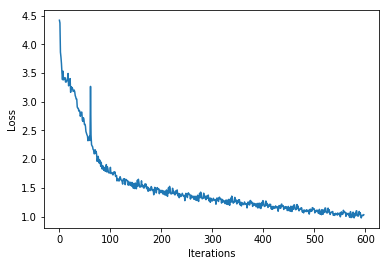

N/A%|#                                              |Time:  0:00:03  Loss: 0.99


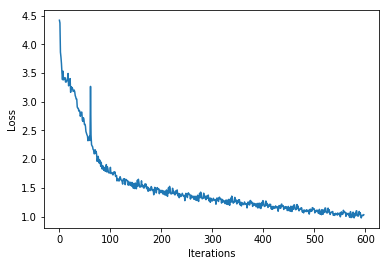

In [0]:
# Training step
EPOCHS = 10 
optimizer = tf.train.AdamOptimizer()
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

history = []
plotter = util.PeriodicPlotter(sec=1, xlabel='Iterations', ylabel='Loss')
for epoch in range(EPOCHS):

    # Initialize the hidden state at the start of every epoch; initially is None
    hidden = model.reset_states()
    
    # Enumerate the dataset for use in training
    custom_msg = util.custom_progress_text("Loss: %(loss)2.2f")
    bar = util.create_progress_bar(custom_msg)
    for inp, target in bar(dataset):
        # Use tf.GradientTape()
        with tf.GradientTape() as tape:
            predictions = model(inp)
            loss = compute_loss(target, predictions)
        
        # Now, compute the gradients and try to minimize
        grads = tape.gradient(loss, model.trainable_variables) # TODO
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Update the progress bar!
        history.append(loss.numpy().mean())
        custom_msg.update_mapping(loss=history[-1])
        plotter.plot(history)
    
    # Update the model with the changed weights!
    model.save_weights(checkpoint_prefix.format(epoch=epoch))



In [0]:
#Generate music
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  bar = util.create_progress_bar()
  for i in bar(range(generation_length)):
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy() # TODO 
      
      # Pass the prediction along with the previous hidden state
          # as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id]) # TODO 

  return (start_string + ''.join(text_generated))

In [0]:
# Different characters outputs different results, let's try X
text = generate_text(model, start_string="X")

100%|#########################################################|Time:  0:00:05  


In [0]:
#This is the output text
print(text)
#Now we can play it
util.play_generated_song(text)

Output hidden; open in https://colab.research.google.com to view.